## Incompleteness Corrections

---

### Imports

In [10]:
import utils
import matplotlib.pyplot as plt
import numpy as np
import os
from astropy import units as u
from tabulate import tabulate
from scipy.interpolate import interp1d
utils.rcparams()

In [15]:
# Load the background and Herschel data
sgp_background = utils.full_loader('Background_VIKING_KiDS_HELP_all_15')
sgp_spire = utils.full_loader('Herschel_VIKING_KiDS_HELP_all_15')

# Apply restrictions to all datasets
sgp_background_gals = sgp_background[sgp_background['SG'] == 1]
sgp_spire_gals = sgp_spire[sgp_spire['SG'] == 1]

# Load the reliable sample
sgp = utils.full_loader('HATLAS_SGP_DR3_15')
sgp_reliable_gals = sgp[(sgp['SG'] == 1) & (sgp['reliability'] >= 0.8) & (sgp['z1_median'] > 0)]
sgp_reliable_gals = sgp_reliable_gals.reset_index()

---

### Sub-mm Incompleteness

In [16]:
# Load completeness from Valiante+2016
valiante_2016 = utils.full_loader('Valiante+2016_completeness')

cs_flux_obs_mjy = valiante_2016['flux_measured_mjy']
cs_flux_obs_jy = cs_flux_obs_mjy/1000

# Submm correction factor
cs_250 = 1/valiante_2016['completeness_250']
cs_350 = 1/valiante_2016['completeness_350']
cs_500 = 1/valiante_2016['completeness_500']

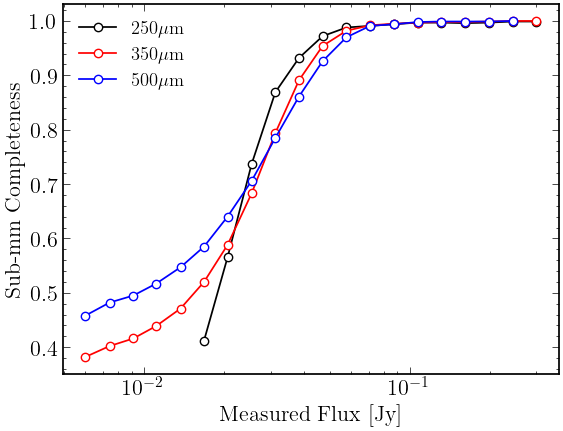

In [17]:
# Plot of completeness
fig, ax = plt.subplots()
ax.plot(cs_flux_obs_jy, valiante_2016['completeness_250'], 'o-', label=r'250$\mu$m')
ax.plot(cs_flux_obs_jy, valiante_2016['completeness_350'], 'o-', label=r'350$\mu$m')
ax.plot(cs_flux_obs_jy, valiante_2016['completeness_500'], 'o-', label=r'500$\mu$m')
ax.set_xlabel(r'Measured Flux [Jy]')
ax.set_ylabel(r'Sub-mm Completeness')
ax.semilogx()
ax.legend()
plt.savefig(os.getcwd() + '/figures/Figure_2_1.pdf', format = 'pdf', dpi = 1000, bbox_inches='tight')
plt.show()

In [18]:
# Interpolation of sub-mm completeness
mjy_range = np.logspace(np.log10(20), np.log10(250), 10)
jy_range = mjy_range/1000

interp_250 = interp1d(cs_flux_obs_jy, valiante_2016['completeness_250'], bounds_error=False, fill_value="extrapolate")
interp_350 = interp1d(cs_flux_obs_jy, valiante_2016['completeness_350'], bounds_error=False, fill_value="extrapolate")
interp_500 = interp1d(cs_flux_obs_jy, valiante_2016['completeness_500'], bounds_error=False, fill_value="extrapolate")

# Calculate completeness and correction factors for any value
completeness_250 = interp_250(jy_range)
correction_factor_250 = 1/completeness_250

submm_completeness_table = tabulate(np.array([mjy_range, completeness_250, correction_factor_250]).T, headers=[r'Flux density', r'Completeness', r'c(submm)'], floatfmt=".3f")
print(submm_completeness_table)

  Flux density    Completeness    c(submm)
--------------  --------------  ----------
        20.000           0.541       1.849
        26.479           0.762       1.313
        35.058           0.903       1.107
        46.416           0.969       1.032
        61.453           0.989       1.011
        81.363           0.993       1.007
       107.722           0.997       1.003
       142.621           0.997       1.003
       188.826           0.997       1.003
       250.000           0.999       1.001


---

### ID Incompleteness

In [19]:
# Important parameter values for ID completeness
N_spire = 193527
N_back = 844715
n_bins = 20
r = 15*u.arcsec
Q = 0.835
Q_err = 0.009

In [20]:
# Calculate ID completeness function
z_bins, z_bin_centers, comp, comp_err, c_factor, c_factor_err = utils.id_completeness(sgp_spire_gals, sgp_background_gals, sgp_reliable_gals, N_spire, N_back, 'z1_median', n_bins, (0,2), Q, Q_err, r)

In [21]:
# Literature redshift bins and completeness functions
smith_z_bins = np.array([0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,1.1])
smith_z_bin_centers = (smith_z_bins[:-1] + smith_z_bins[1:]) / 2
smith_comp = np.array([93.2,83.2,74.2,55.6,53.1,45,54.1,43.3,52.7])/100
smith_comp_err = np.array([7.5,4.8,4.2,4.8,6,7.4,7,10,16.7])/100

fleuren_z_bins = np.array([0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1,1.1])
fleuren_z_bin_centers = (fleuren_z_bins[:-1] + fleuren_z_bins[1:]) / 2
fleuren_comp = np.array([117.8,108.6,87,65.9,50.6,46.3,59.3,56.1,55.8,61,55])/100
fleuren_comp_err = np.array([5.8,3.8,2.9,1.4,1.3,0.9,1.8,2.7,3.6,5.6,5.6])/100

bourne_z_bins = np.array([0.,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1,1.5,2,2.5,3])
bourne_z_bin_centers = (bourne_z_bins[:-1] + bourne_z_bins[1:]) / 2
bourne_comp = np.array([91.3,87.7,80.4,72.2,68.9,66.4,60.5,56.2,58.8,65.9,76.1,78.9,76,99.6])/100
bourne_comp_err = np.array([2.2,1.5,1.5,1.3,1.5,1.8,1.7,1.8,3.9,9.9,9.1,9.9,14,31.4])/100

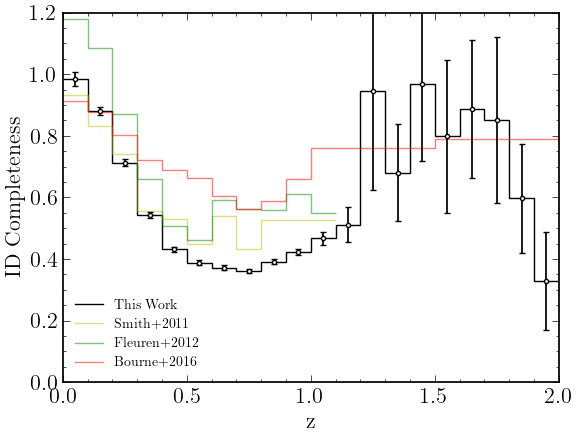

In [22]:
# Plot of ID completeness with literature
alpha = 0.1

fig, ax = plt.subplots()
ax.stairs(comp, z_bins, baseline=None, color='k', label='This Work')
ax.errorbar(z_bin_centers, comp, yerr=comp_err, fmt='.', c='k')
ax.stairs(smith_comp, smith_z_bins, baseline=None, color='y', alpha=0.5, label='Smith+2011')
ax.stairs(fleuren_comp, fleuren_z_bins, baseline=None, color='g', alpha=0.5, label='Fleuren+2012')
ax.stairs(bourne_comp, bourne_z_bins, baseline=None, color='r', alpha=0.5, label='Bourne+2016')
ax.set_xlabel(r'z')
ax.set_ylabel(r'ID Completeness')
ax.set_xlim(0, 2)
ax.set_ylim(0, 1.2)
ax.legend(fontsize=10)
plt.savefig(os.getcwd() + '/figures/Figure_3_2.pdf', dpi=1000, bbox_inches='tight')
plt.show()

In [23]:
# Interpolation of ID completeness
interp_z = interp1d(z_bin_centers, comp, bounds_error=False, fill_value="extrapolate")

# Calculate completeness and correction factors for any value
z_range = np.linspace(0.05,0.95,10)
completeness_z = interp_z(z_range)
correction_factor_z = 1/completeness_z

id_completeness_table = tabulate(np.array([z_range, completeness_z, correction_factor_z]).T, headers=[r'Redshift', r'Completeness', r'c(ID)'], floatfmt=".3f")
print(id_completeness_table)

  Redshift    Completeness    c(ID)
----------  --------------  -------
     0.050           0.984    1.016
     0.150           0.881    1.135
     0.250           0.713    1.403
     0.350           0.542    1.844
     0.450           0.432    2.313
     0.550           0.387    2.581
     0.650           0.372    2.685
     0.750           0.360    2.776
     0.850           0.392    2.552
     0.950           0.422    2.369


Note we can make a weighted average of the correction factors and compare to a nominal value of 1/(Q/R) = 1/(0.57/0.83) ~ 1.46.

In [24]:
# Median correction factor for ID sample
print('The median correction factor for each SGP galaxy in the reliable sample = {:.2f}'.format(np.nanmedian(1/interp_z(sgp_reliable_gals['z1_median']))))

The median correction factor for each SGP galaxy in the reliable sample = 2.10


---

### Validity Tests

There are two simply validity tests that we can make to ensure our ID completeness functions are consistent:

i) The integral of the reliable sample distribution over all redshifts should yield the total number of reliable IDs
$$ \int_z n_{\textrm{reliable}}(z) dz = N_{\textrm{reliable}} $$

ii) The integral of the reliable sample distribution multiplied by the correction factors should yield the total number of Herschel objects that have visible near-IR counterparts
$$ \int_z c_z n_{\textrm{reliable}}(z) dz = QN_{\textrm{250\,um}} $$

In [25]:
# Test 1

# LHS
n_reliable, _ = np.histogram(sgp_reliable_gals['z1_median'], bins=n_bins, range=(0, 200))
print('LHS: ', np.sum(n_reliable))

# RHS
N_reliable = len(sgp_reliable_gals)
print('RHS: ', N_reliable)

LHS:  81895
RHS:  81895


In [26]:
# Test 2

# LHS
n_reliable, _ = np.histogram(sgp_reliable_gals['z1_median'], bins=n_bins, range=(0, 2))
integral = c_factor*n_reliable
print('LHS: ', np.sum(integral))

# RHS
observed_n = Q*N_spire
print('RHS: ', observed_n)

LHS:  161595.04500000004
RHS:  161595.04499999998


---

### Save Results

In [27]:
# Save correction factors
sgp_correction_factors = {'Flux_correction': (cs_flux_obs_jy, cs_250),
                          'ID_correction': (z_bin_centers, c_factor)}

utils.save_result(sgp_correction_factors, 'sgp_correction_factors')